# Exercise 3: 2D Ising model

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, BSpline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import clear_output

## Core Task 1

The Hamiltonian of the system:
$$\beta E=-\beta J\sum_{\langle i,j\rangle} s_is_j-\beta\mu H\sum_{i=1}^N s_i$$

The first term sums over all neighbouring spins $\langle i,j\rangle$ 

When a spin $i$ is flipped, the difference in energy is:
$$\beta\Delta E_i=\Delta s_i\left[-\beta J\sum_{<j>} s_j-\beta\mu H\right]$$

### The simulation
A class "Ising" is defined, containing parameters of the simulation. This includes the number of spins, the coupling constant, the magnetic field, and the starting conditions (spins all in one direction, a randomised configuration, or a pre-determined configuration (perhaps from a previous simulation)

To vectorise the simulation, np.where is used to determine what spins should be flipped, for all spins on the checkerboard simultaneously.

In [43]:
class Ising:
    def __init__(self, size, coupling, field, start):
        self.size = size
        self.coupl = coupling
        self.field = field
        self.odd = np.indices((size,size)).sum(axis=0) % 2
        self.even = (np.indices((size,size)).sum(axis=0)+1) % 2
        if np.isscalar(start) == False:
            self.latt = start
        elif start == 0:
            self.latt = np.random.rand(self.size, self.size)
            self.latt[self.latt >= 0.5] = 1
            self.latt[self.latt < 0.5] = -1
        elif start == 1:
            self.latt = np.ones((self.size, self.size))
        elif start == -1:
            self.latt = -np.ones((self.size, self.size))
        self.neigh = np.roll(self.latt, 1, axis=1) + np.roll(self.latt, -1, axis=1) + np.roll(self.latt, 1, axis=0) + np.roll(self.latt, -1, axis=0)
    
    def find_neigh(self):
        self.neigh = np.roll(self.latt, 1, axis=1) + np.roll(self.latt, -1, axis=1) + np.roll(self.latt, 1, axis=0) + np.roll(self.latt, -1, axis=0)

    def flip(self, i, j):
        flip_or_not = 1
        curr_spin = self.latt[i,j]
    
        neigh_sum = self.neigh[i,j]
        Delta_E = 2*curr_spin*(self.field + neigh_sum*self.coupl)

        prob = np.random.rand()
        if np.exp(-Delta_E) > prob:
            flip_or_not = -1
        return flip_or_not

    def propagate(self, time_tot):
        for t in range(time_tot):
            odd_spins = self.odd*self.latt
            even_spins = self.even*self.latt
            prob_mat = np.random.rand(self.size, self.size)
            
            flipped_odd = np.where(np.logical_and(np.exp(-odd_spins*2*(self.field + self.neigh*self.coupl)) > prob_mat, odd_spins != 0), odd_spins*-1, odd_spins)
            self.latt = flipped_odd + even_spins
            Ising.find_neigh(self)
            flipped_even = np.where(np.logical_and(np.exp(-even_spins*2*(self.field + self.neigh*self.coupl)) > prob_mat, even_spins != 0), even_spins*-1, even_spins)
            self.latt = flipped_odd + flipped_even
            Ising.find_neigh(self)

    def Mag(self):
        return np.average(self.latt)

    def Ham(self):
        coupling_E = 0
        field_E = 0
        for i in range(self.size):
            for j in range(self.size):
                coupling_E -= 0.5*self.coupl*self.latt[i,j]*self.neigh[i,j]
                field_E -= self.field*self.latt[i,j]
        return coupling_E + field_E

    def sample(self, eq_time, samp_time, samp_interval):
        self.propagate(eq_time)
        samp_times = np.arange(0, samp_time, samp_interval)
        mag_samples = [Ising.Mag(self)]
        E_samples = [Ising.Ham(self)]
        for t in samp_times:
            self.propagate(samp_interval)
            mag_samples.append(Ising.Mag(self))
            E_samples.append(Ising.Ham(self))
        return mag_samples, E_samples

### Effect of external magnetic field
Two sets of simulation are done to simulate the effect of a magnetic field.
For the first set, all spins are aligned in the $+$ direction. For the second set, all spins are initially random.

In [60]:
fields = [-2,-1,-0.5-0.1,0.1,0.5,1,2]
steps = [1, 10, 100,1000,10000,100000]
sim_mats = {}

for i in range(len(fields)):
    sim_latt = Ising(50, 0.1, fields[i], 1)
    for j in range(len(steps)):
        if j == 0:
            Ising.propagate(sim_latt, 1)
        else:
            Ising.propagate(sim_latt, steps[j]-steps[j-1])
        sim_mats[(fields[i], steps[j])] = np.array(sim_latt.latt)
        clear_output(wait = True)
        print('Magnetic field = ',fields[i], '\n', 'Time = ', steps[j])

Magnetic field =  2 
 Time =  100000


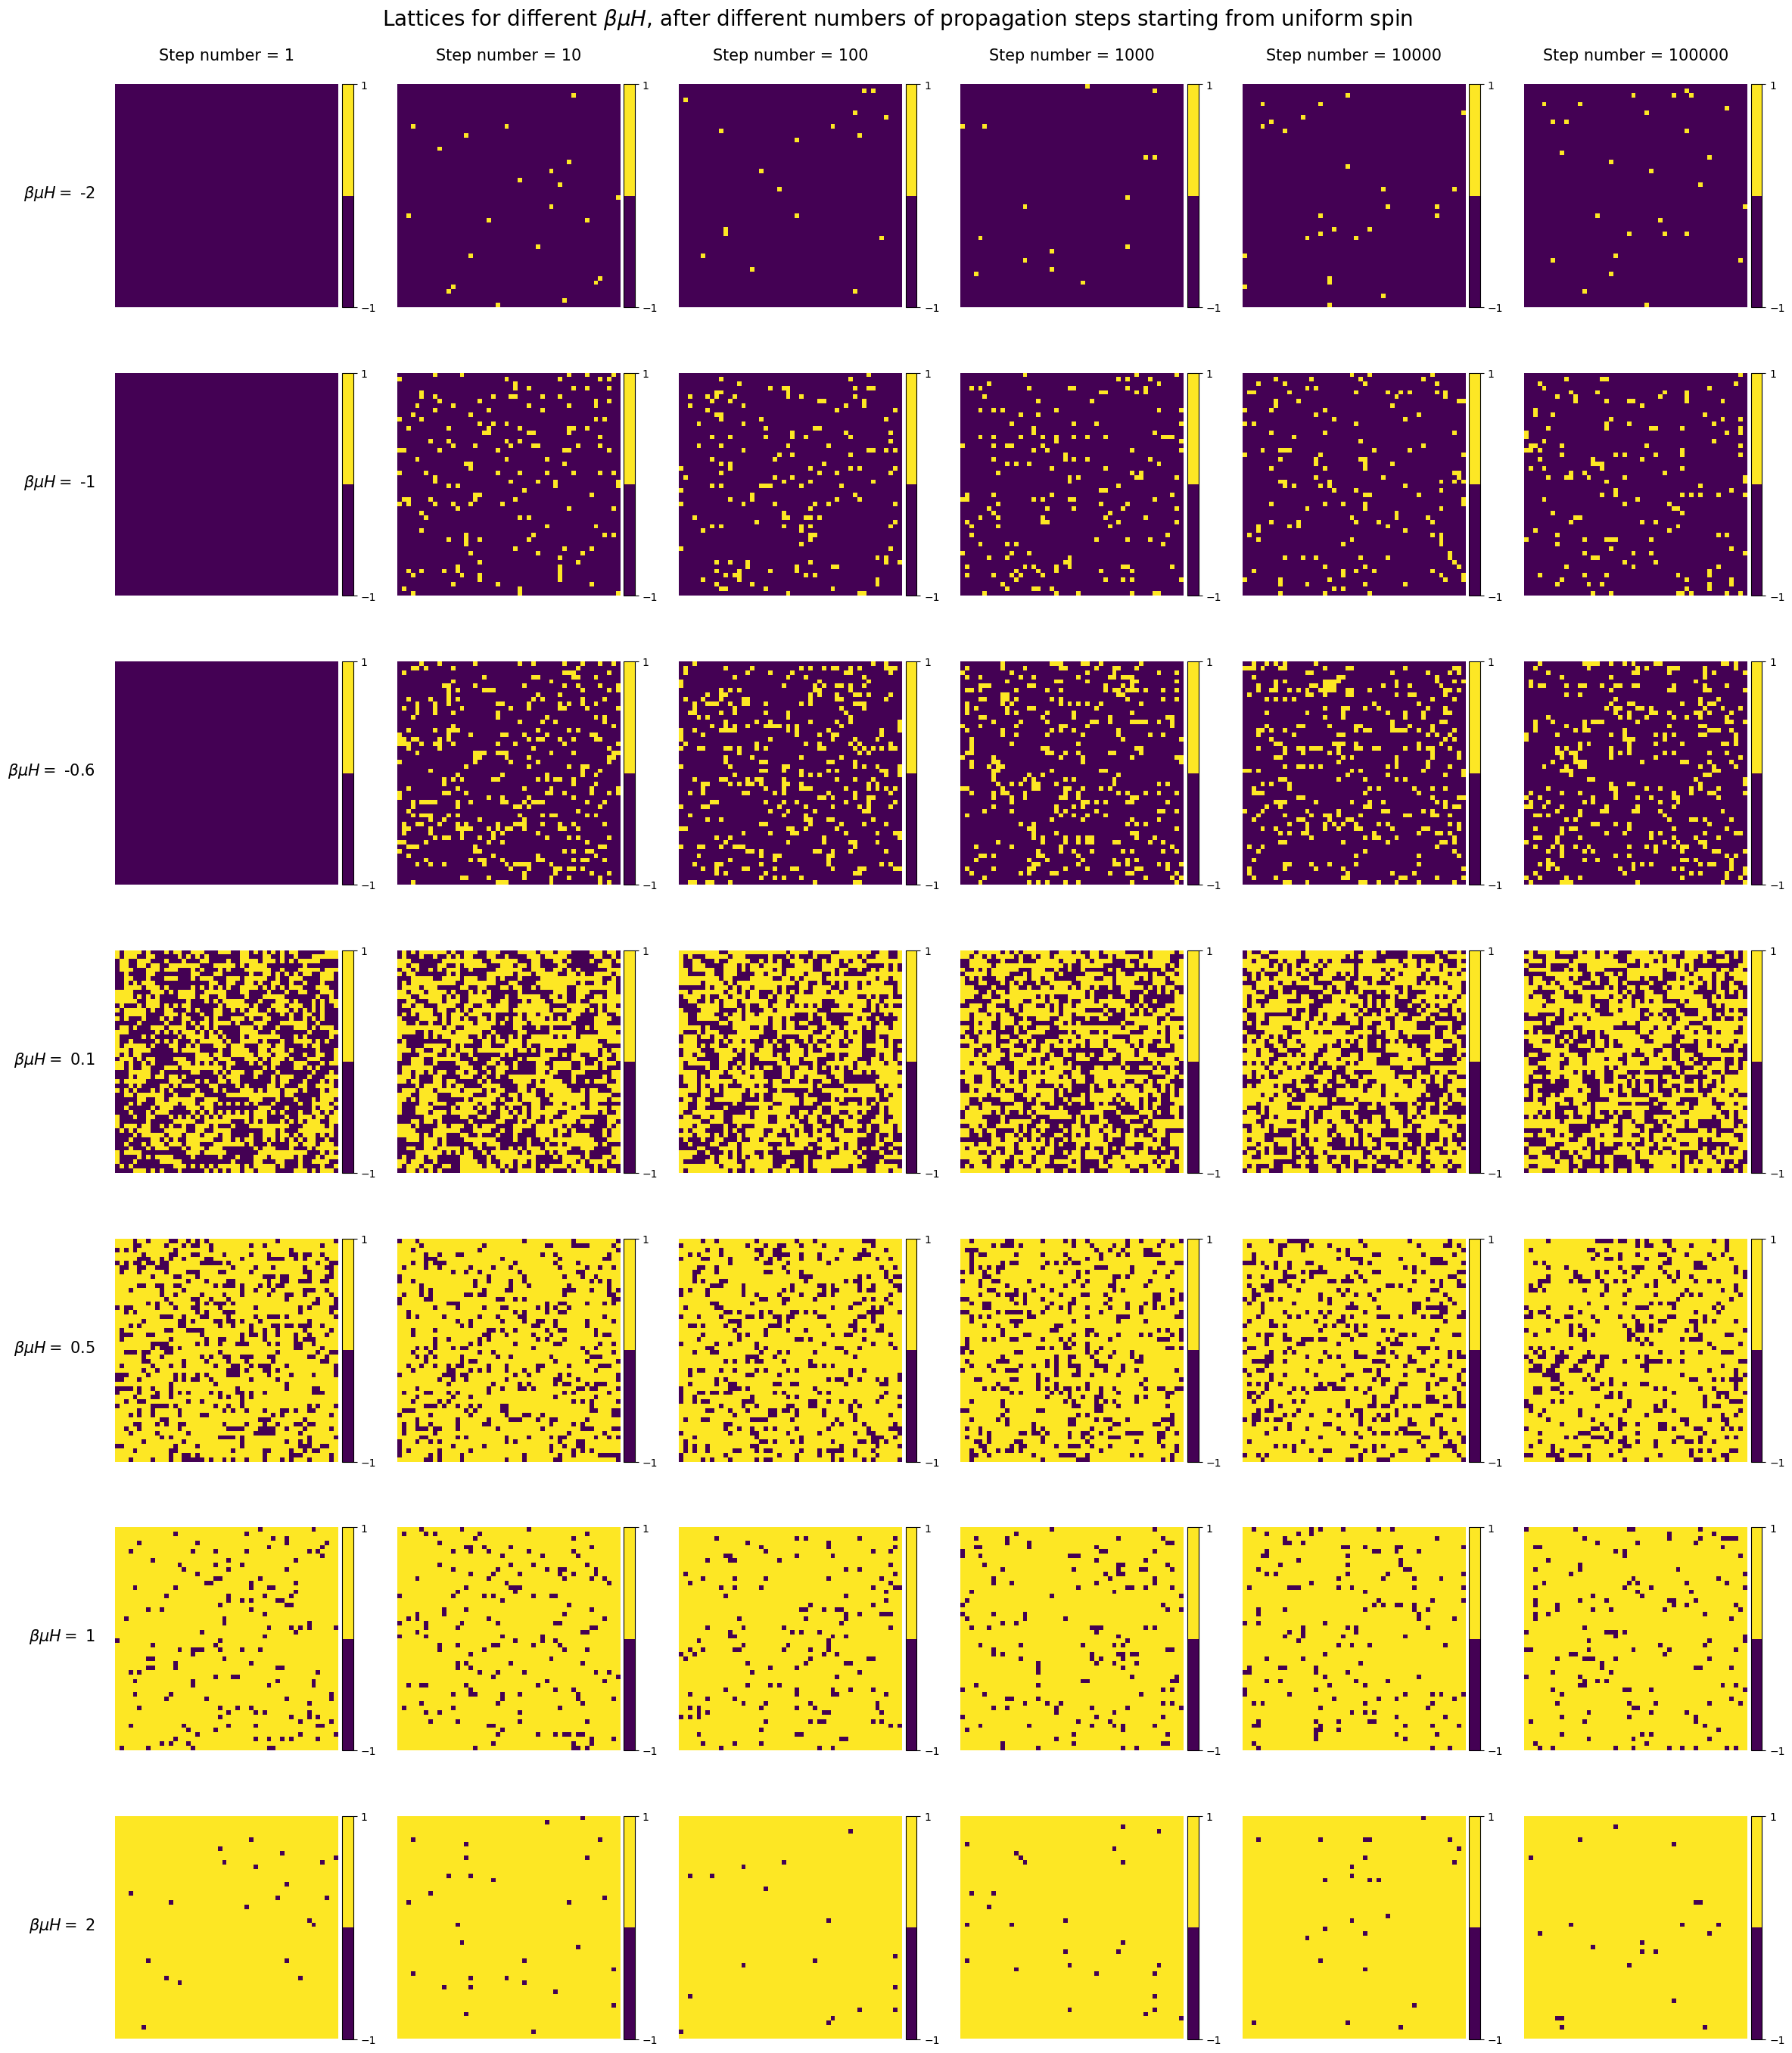

In [61]:
fig, axs = plt.subplots(len(fields), len(steps), figsize = (4*len(steps), 4*len(fields)))
colors = plt.get_cmap('viridis',2)

for i in range(len(fields)):
    for j in range(len(steps)):
        mat1 = axs[i, j].matshow(sim_mats[(fields[i], steps[j])], cmap=colors, vmin=-1, vmax=1)
        axs[i, j].axis('off')
        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(mat1, cax=cax, orientation='vertical', ticks=[-1,1])
        if j == 0:
            axs[i, 0].text(-5, 25, r'$\beta\mu H =$ ' + str(fields[i]), horizontalalignment = 'right', fontsize=15)
        if i == 0:
            axs[i, j].set_title('Step number = ' + str(steps[j]), fontsize=15)
fig.suptitle(r'Lattices for different $\beta\mu H$, after different numbers of propagation steps starting from uniform spin', fontsize = 20)
plt.tight_layout(pad=2)
plt.show()

All lattices start off with spins pointing up. For negative fields, all spins flip after only one step as it is energetically favourable. Afterwards, some spins flip upwards as the algorithm generates a low probability bound $p$ for some propagation steps.
For positive fields, some spins flip down after one step (also due to low $p$)

After many steps, a large proportion of spins align in the direction of the field, with the anti-aligned spins being in random positions.

In [54]:
fields = [-2,-1,-0.5-0.1,0.1,0.5,1,2]
steps = [1, 10, 100,1000,10000,100000]
sim_mats = {}

for i in range(len(fields)):
    sim_latt = Ising(50, 0.1, fields[i], 0)
    for j in range(len(steps)):
        if j == 0:
            Ising.propagate(sim_latt, 1)
        else:
            Ising.propagate(sim_latt, steps[j]-steps[j-1])
        sim_mats[(fields[i], steps[j])] = np.array(sim_latt.latt)
        clear_output(wait = True)
        print('Magnetic field = ',fields[i], '\n', 'Time = ', steps[j])

Magnetic field =  2 
 Time =  100000


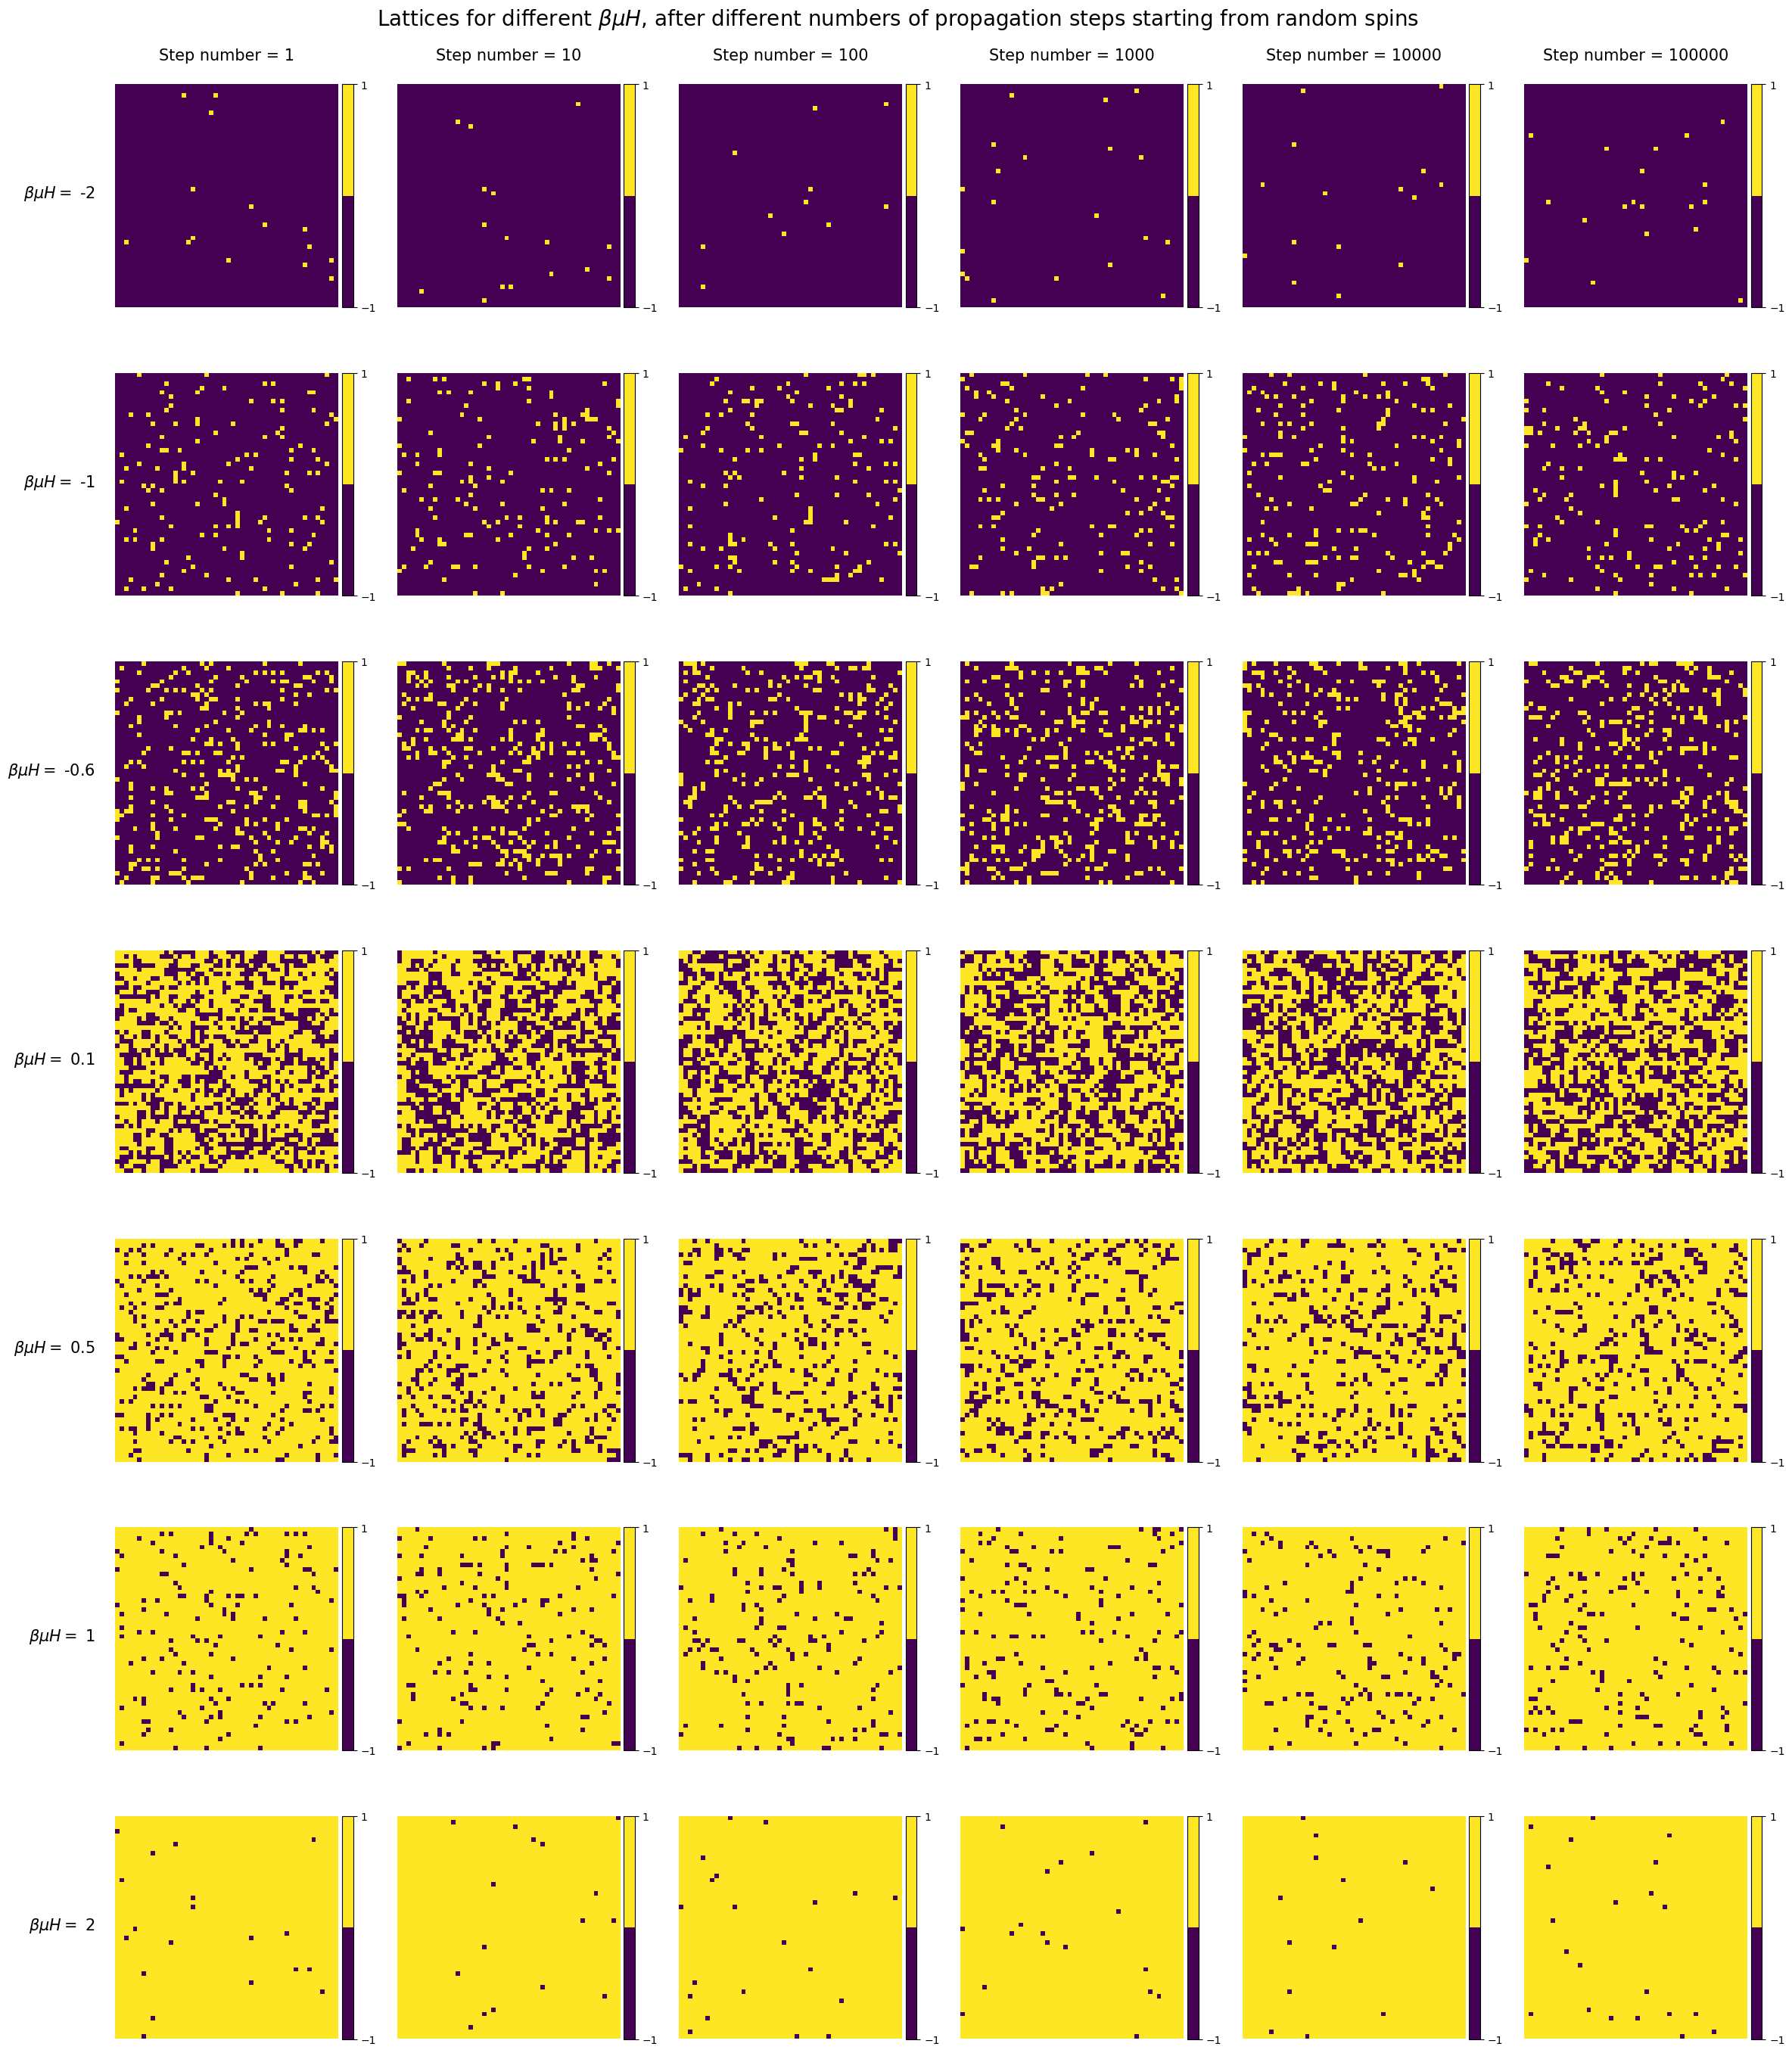

In [58]:
fig, axs = plt.subplots(len(fields), len(steps), figsize = (4*len(steps), 4*len(fields)))
colors = plt.get_cmap('viridis',2)

for i in range(len(fields)):
    for j in range(len(steps)):
        mat1 = axs[i, j].matshow(sim_mats[(fields[i], steps[j])], cmap=colors, vmin=-1, vmax=1)
        axs[i, j].axis('off')
        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(mat1, cax=cax, orientation='vertical', ticks=[-1,1])
        if j == 0:
            axs[i, 0].text(-5, 25, r'$\beta\mu H =$ ' + str(fields[i]), horizontalalignment = 'right', fontsize=15)
        if i == 0:
            axs[i, j].set_title('Step number = ' + str(steps[j]), fontsize=15)
fig.suptitle(r'Lattices for different $\beta\mu H$, after different numbers of propagation steps starting from random spins', fontsize = 20)
plt.tight_layout(pad=2)
plt.show()

When starting from random spins, the system still equilibriates quickly. With enough steps, initial conditions do not matter (at least in the case of no ferromagnetic coupling)

### Magnetisation as a function of time

In [62]:
mag_time = np.arange(0, 10000, 50)
mag_latt = Ising(100, 0, 0.5, 1)
mag_values = [Ising.Mag(mag_latt)]
for i in range(len(mag_time)):
    mag_latt.propagate(200)
    mag_values.append(Ising.Mag(mag_latt))

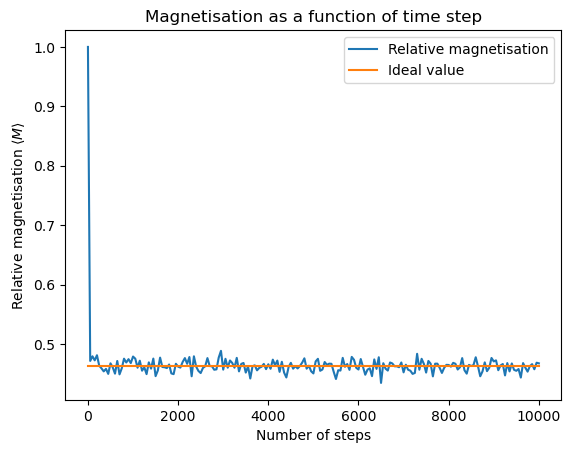

In [68]:
plt.plot(np.arange(0, 10050, 50), mag_values, label='Relative magnetisation')
plt.plot(np.arange(0, 10050, 50), np.repeat(np.tanh(0.5), 201), label='Ideal value')
plt.title('Magnetisation as a function of time step')
plt.xlabel('Number of steps')
plt.ylabel(r'Relative magnetisation $\langle M\rangle$')
plt.legend()
plt.show()

Starting from a lattice of uniform spin, magnetisation quickly falls to the equilibrium value, as spins start to flip down.

### Magnetisation as a function of field

In [64]:
fields = np.linspace(-3, 3, 50)
cal_mag = []
for i in fields:
    mag_latt = Ising(100, 0, i, 0)
    mag_sample_values = mag_latt.sample(2000, 500, 10)[0]
    cal_mag.append(np.average(mag_sample_values))
    clear_output(wait = True)
    print('Simulating field value ',str(i))

Simulating field value  3.0


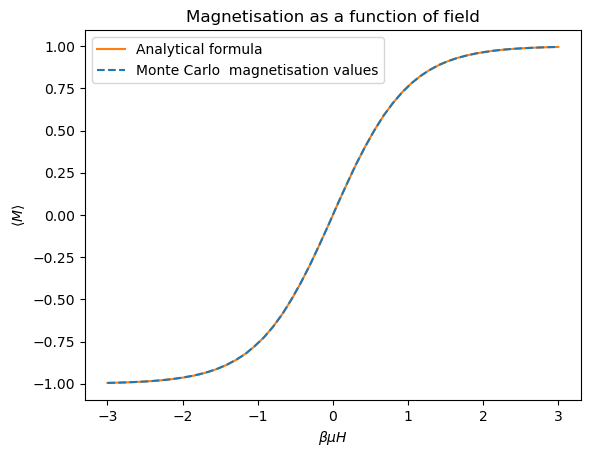

In [69]:
plt.plot(fields, np.tanh(fields), color='tab:orange', label='Analytical formula')
plt.plot(fields, cal_mag, color='tab:blue', label='Monte Carlo  magnetisation values', linestyle='dashed')
plt.title('Magnetisation as a function of field')
plt.xlabel(r'$\beta\mu H$')
plt.ylabel(r'$\langle M \rangle$')
plt.legend()
plt.show()

The Metropolis-Hastings algorithm is successful in re-creating the analytical formula for relative magnetisation:
$$\langle M\rangle = \mathrm{tanh}(\beta \mu H)$$

## Core Task 1 conclusion
The Metropolis-Hastings algorithm can be used to propagate the lattice to states close to equilibrium in a finite number of steps. It is successful in reproducing the theoretical result for relative magnetisation in the case of no coupling.

## Core Task 2
The same algorithm is used as in the no coupling case, but this time with non-zero $\beta J$ and zero $\beta\mu H$

In [70]:
ferro = Ising(100, 0.2, 0, 1)
anti_ferro = Ising(100, -0.2, 0, 1)
steps = [1, 10, 100, 1000, 10000, 100000]
sim_mats = {}

for j in range(len(steps)):
    if j == 0:
        ferro.propagate(1)
    else:
        ferro.propagate(steps[j]-steps[j-1])
    sim_mats[(0.2, steps[j])] = np.array(ferro.latt)
    clear_output(wait = True)
    print('Simulating ferromagnetic coupling','\n', 'Time = ', steps[j])

for j in range(len(steps)):
    if j == 0:
        anti_ferro.propagate(1)
    else:
        anti_ferro.propagate(steps[j]-steps[j-1])
    sim_mats[(-0.2, steps[j])] = np.array(anti_ferro.latt)
    clear_output(wait = True)
    print('Simulating anti-ferromagnetic coupling','\n', 'Time = ', steps[j])

Simulating anti-ferromagnetic coupling 
 Time =  100000


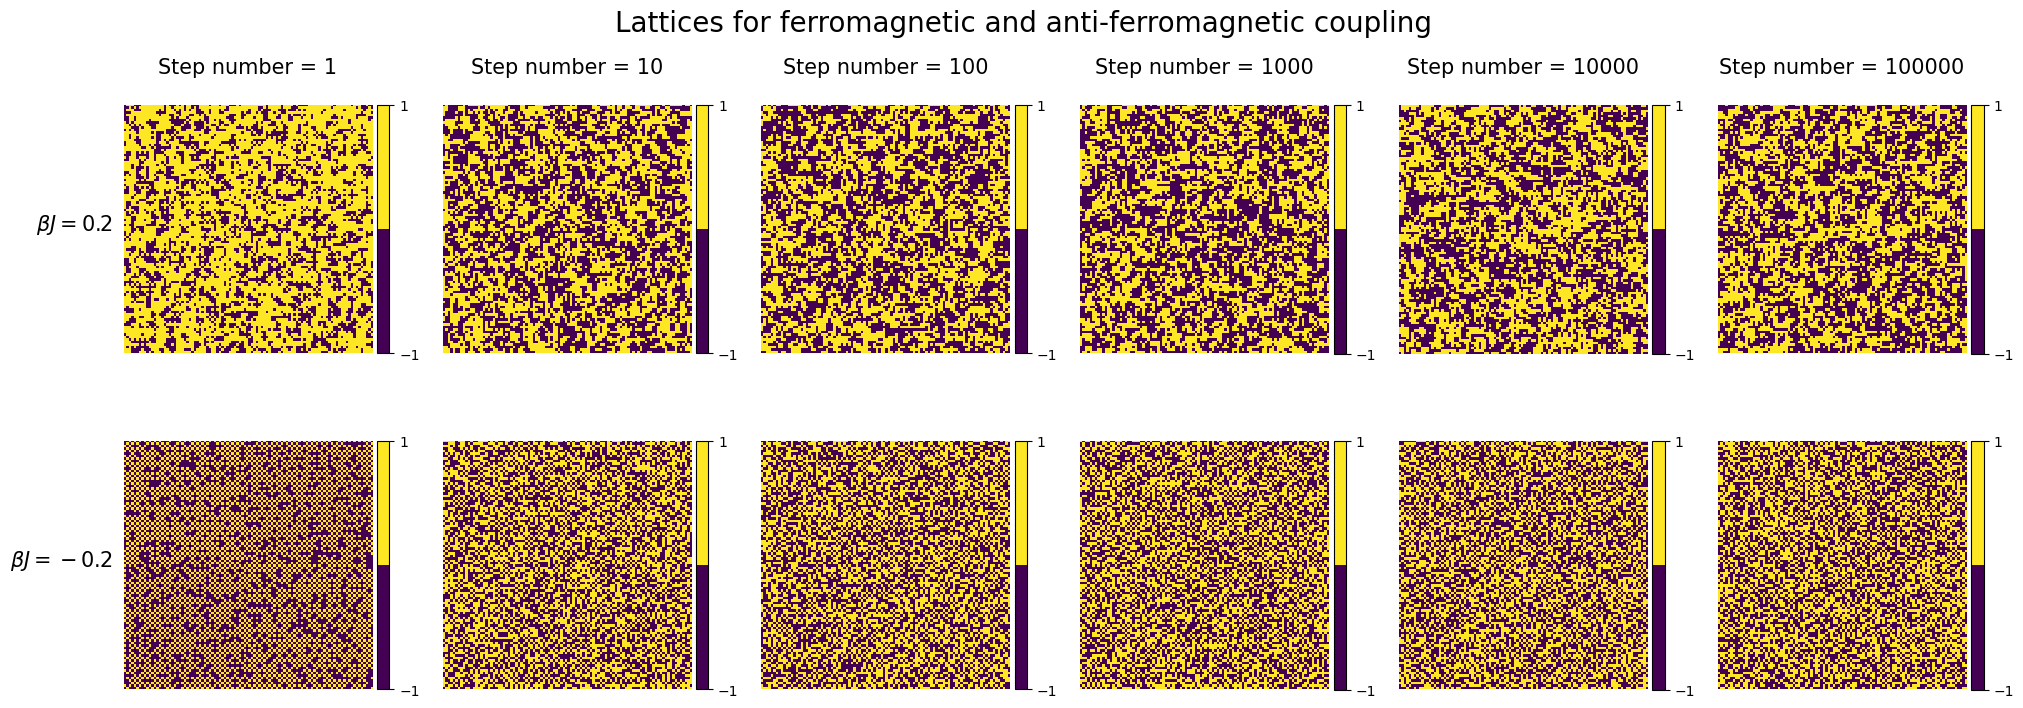

In [71]:
fig, axs = plt.subplots(2, len(steps), figsize = (4*len(steps), 8))
colors = plt.get_cmap('viridis',2)

for j in range(len(steps)):
    mat1 = axs[0, j].matshow(sim_mats[(0.2, steps[j])], cmap=colors, vmin=-1, vmax=1)
    axs[0, j].axis('off')
    divider = make_axes_locatable(axs[0,j])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(mat1, cax=cax, orientation='vertical', ticks=[-1,1])
    if j == 0:
        axs[0, 0].text(-5, 50, r'$\beta J = 0.2$' , horizontalalignment = 'right', fontsize=15)
    axs[0, j].set_title('Step number = ' + str(steps[j]), fontsize=15)
        
    mat2 = axs[1, j].matshow(sim_mats[(-0.2, steps[j])], cmap=colors, vmin=-1, vmax=1)
    axs[1, j].axis('off')
    divider = make_axes_locatable(axs[1,j])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(mat2, cax=cax, orientation='vertical', ticks=[-1,1])
    if j == 0:
        axs[1, 0].text(-5, 50, r'$\beta J = -0.2$' , horizontalalignment = 'right', fontsize=15)
fig.suptitle(r'Lattices for ferromagnetic and anti-ferromagnetic coupling', fontsize = 20)
plt.show()

For $\beta J>0$, spins tend to align. This leads to the formation of magnetic domains which have a width up to the order of the lattice width.
For $\beta J<0$, spins tend to anti-align, leading to the formation of much smaller domains, typically only a few spins wide.

### Critical behaviour
The critical coupling $\beta_cJ$ for Onsanger's solution is:
$$\beta_c J=\frac{\ln(1+\sqrt{2})}{2}\approx 0.44$$

For the purposes of this simulation, the starting lattice for each temperature is the final lattice for the previous temperature.

In [86]:
couplings = np.linspace(-0.5,1.5,100)
mag_latt = Ising(200, couplings[0], 0, 0)
mag_sample_values = mag_latt.sample(2000, 1000, 10)[0]
mag_values = [np.average(mag_sample_values)]
pre_insert = mag_latt.latt

In [88]:
for i in couplings[1:]:
    clear_output(wait=True)
    print('Simulating ferromagnetic coupling ',str(i))
    mag_latt = Ising(200, i, 0, pre_insert)
    mag_sample_values = mag_latt.sample(2000, 1000, 10)[0]
    mag_values.append(np.average(mag_sample_values))
    pre_insert = mag_latt.latt

Simulating ferromagnetic coupling  1.5


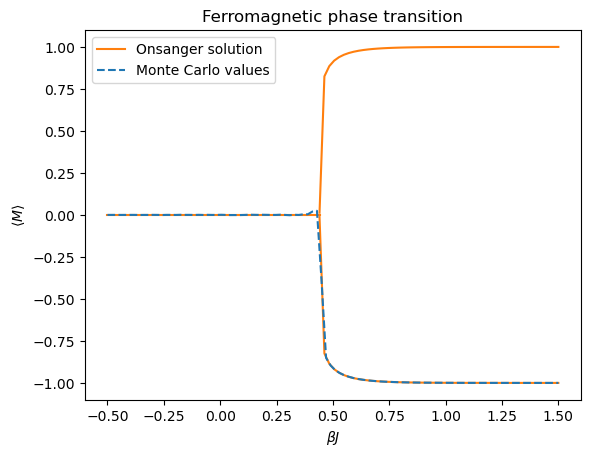

In [89]:
Tc = np.log(1+np.sqrt(2))/2
sol_T = np.linspace(Tc+1e-16, 1.5, 50)

plt.plot([-0.5,Tc],[0,0], color='tab:orange', label='Onsanger solution')
plt.plot(sol_T, -(1-np.sinh(2*sol_T)**(-4))**0.125, color='tab:orange')
plt.plot(sol_T, (1-np.sinh(2*sol_T)**(-4))**0.125, color='tab:orange')
plt.plot(couplings, mag_values, color='tab:blue', label='Monte Carlo values', linestyle='dashed')
plt.title('Ferromagnetic phase transition')
plt.xlabel(r'$\beta J$')
plt.ylabel(r'$\langle M\rangle$')
plt.legend()
plt.show()

Values of relative magnetisation obtained by sampling the system near equilibrium re-creates Onsager's analytical formula.

## Core Task 2 Conclusion
The Metropolis-Hastings algorithm is also successf

## Supplementary task
From the fluctuation-dissipation theorem:
$$\frac{C}{k_B}=\beta^2\sigma_E^2=(\beta J)^2\frac{\sigma_E^2}{J^2}$$
In this set of simulations, $J=0.2$, and $\beta J$ is varied, with the critical value at $\approx0.44$

In [22]:
latt_sizes = [50, 100, 250]
couplings = np.concatenate((np.linspace(0.2,0.38,20), np.linspace(0.4, 0.48, 20), np.linspace(0.5, 0.8, 20)))
sigma_E_values = {}
pre_inserts = {}

for i in latt_sizes:
    mag_latt = Ising(i, couplings[0], 0, 0)
    E_vals = mag_latt.sample(4000, 2000, 20)[1]
    sigma_E_values[i] = [np.std(E_vals)]
    pre_inserts[i] = mag_latt.latt
    clear_output(wait=True)
    print('Lattice size = ',str(i),'\nFerromagnetic coupling = ',str(couplings[0]))
    
for i in latt_sizes:
    for j in couplings[1:]:
        mag_latt = Ising(i, j, 0, pre_inserts[i])
        E_vals = mag_latt.sample(4000, 2000, 20)[1]
        sigma_E_values[i].append(np.std(E_vals))
        pre_inserts[i] = mag_latt.latt
        clear_output(wait=True)
        print('Lattice size = ',str(i),'\nFerromagnetic coupling = ',str(j))

Lattice size =  250 
Ferromagnetic coupling =  0.8


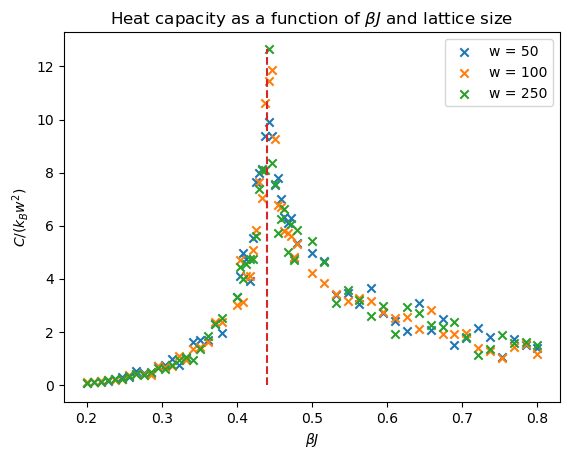

In [85]:
for i in latt_sizes:
    heat_caps = couplings**2*np.array(sigma_E_values[i])**2/(0.2**2*i**2)
    plt.scatter(couplings, heat_caps, label='w = '+str(i), marker='x')
plt.plot([Tc,Tc],[0, np.max(heat_caps)], color='tab:red', linestyle='dashed')
plt.legend()
plt.xlabel(r'$\beta J$')
plt.ylabel(r'$C/(k_Bw^2)$')
plt.title(r'Heat capacity as a function of $\beta J$ and lattice size')
plt.show()

The heat capacity is seen to peak at $T_c$ for a range of lattice sizes. This corresponds to the fact that heat capacity for the Ising model always diverges at the phase transition. (Onsager, 1944)